# Check for the generated coco annotations

## Start detectron2 training to check the labels
Can bring the assertion error e.g. "not unique id". Generate new labels if this happened.

In [1]:
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import random

In [2]:
os.chdir('/home/p22g5/AnomaliesRecycling/')
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/p22g5/AnomaliesRecycling


In [3]:
from detectron2.data import DatasetCatalog
from detectron2.data.datasets import register_coco_instances
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"  # specify which GPU(s) to be used

DatasetCatalog.clear()
ROOT_DIR = "/home/p22g5/AnomaliesRecycling/"
IM_ROOT_DIR = "/cvhci/temp/p22g5/data/synthesized/"
DATASET_TRAIN_NAME = "polysecure_dataset_train"
DATASET_TEST_NAME = "polysecure_dataset_test"
RETINANET_CONFIG = ROOT_DIR + "image_segmentation/configs/mask_rcnn_R_50_FPN_3x.yaml"

TRAIN_ANNO = IM_ROOT_DIR + "coco_train.json"
TEST_ANNO = IM_ROOT_DIR + "coco_test.json"

TRAIN_IMAGES = IM_ROOT_DIR + "train"
TEST_IMAGES = IM_ROOT_DIR + "test"

register_coco_instances(DATASET_TRAIN_NAME, {}, TRAIN_ANNO, TRAIN_IMAGES)
register_coco_instances(DATASET_TEST_NAME, {}, TEST_ANNO, TEST_IMAGES)


In [4]:
from detectron2.model_zoo import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (DATASET_TEST_NAME,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.OUTPUT_DIR = ROOT_DIR + "output/maskrcnn/"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/13 22:35:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

AssertionError: Annotation ids in '/cvhci/temp/p22g5/data/synthesized/coco_test.json' are not unique!

## Visualisation of generated coco annotations

In [5]:
coco = COCO(TEST_ANNO)
img_dir = TEST_IMAGES

loading annotations into memory...
Done (t=1.11s)
creating index...
index created!


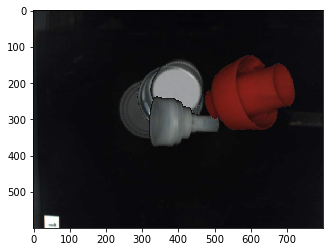

In [8]:
image_id = random.randint(0, 2400)
img = coco.imgs[image_id]
image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image, interpolation='nearest')
plt.grid(False)
plt.show()

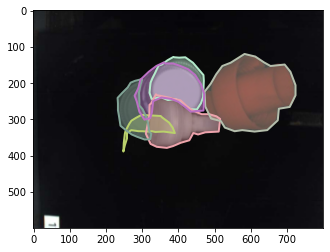

In [9]:
plt.imshow(image)
plt.grid(False)
cat_ids = coco.getCatIds()
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_ids)
coco.showAnns(anns)

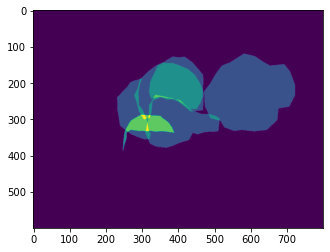

In [10]:
mask = coco.annToMask(anns[0])
for i in range(len(anns)):
    mask += coco.annToMask(anns[i])

plt.imshow(mask)
plt.grid(False)